# Introduction

This notebook programmatically downloads, processes, analyzes, visualizes, and models building violation data retrieved from the City of Chicago's [Open Data Portal](https://data.cityofchicago.org) using the CyberGIS/Jupyter environment. There are three main goals this notebook will aim to achieve: 

- Develop a variety of geospatial visualizations to understand the spatial distribution of building violations in Chicago
- Conduct a point pattern analysis on building violations to identify potential geographic clusters
- Determine whether there is a statistically significant relationship between building violation counts and neighborhood socioeconomic and demographic characterstics using a Poisson or Negative Binomial regression

The notebook is organized as follows: 

    1. Data Sources
    2. Import Libraries
    3. Retrieve Data
    4. Exploratory Analysis
    5. Point Pattern Analysis
    6. Regression Analysis

## Data Sources

There are two primary data sources for this analysis. 

### Building Violations

This dataset contains all of the violations issued by the City of Chicago's Department of Buildings since 2006. 
Each row in the data is a building code violation which contains various attributes, the most important being the following: 

`Violation Date`: The date the violation was cited/issued  
`Violation Code`: The municipal code of the violation  
`Violation Description`: The description of the violation code  
`Violation Status`: Complied, Open, No-entry (inspector was not able to access property)   
`Latitude & Longitude`: The lat/lon where the violation occurred  

Due to the sheer size of the data (and our relevant goals above), we will filter the raw dataset to only keep violations where the `violation date` occurred in 2019.

### U.S. Census American Community Survey (2015-2019) 

As part of the second goal listed above, we need to gather some socioeconomic and demographic data at the neighborhood level for Chicago in 2019. To do this, we will use the [American Community Survey](https://www.census.gov/programs-surveys/acs) (ACS) which collects such data at the census tract level. The census tract is an arbitrary boundary created by the U.S. Census Bureau and is often treated by social scientists as a proxy for neighborhoods. To see how census tracts relate to other geographic boundaries, like counties or cities, you can refer to the [Standard Hierarchy of Census Geographic Entities](https://www2.census.gov/geo/pdfs/reference/geodiagram.pdf) diagram. Survey responses are aggregated by the Census Bureau and provide 'neighborhood level' data on race, ethnicity, poverty, home values, and income (among others). For the purposes of this analysis, we will collect this data programmatically using R and the [tidycensus](https://walker-data.com/tidycensus/) package, write the data to a csv file, upload it to our local CyberGIS environment, and import it into the notebook. 

### Ancillary: Geographic Boundaries for Census Tracts

This is an ancillary data source which provides the polygon boundaries of census tracts within the City of Chicago's municipal borders. Typically, one can access this shapefile data through the U.S. Census website. However, Chicago's Open Data Portal also provides these boundaries in a geojson format so to maximize reproducibility, we will be using the data portal instead of the website.

# Import libraries

In [ ]:
#run below if libraries are not installed
#!pip install sodapy
#!pip install pointpats

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import urllib
import seaborn as sns
import statsmodels.formula.api as smf 
import statsmodels.api as sm
import math
from matplotlib import pyplot as plt
from sodapy import Socrata as soc
from geopandas import GeoSeries, GeoDataFrame, read_file, gpd
from shapely.geometry import shape
from pointpats import centrography

# Retrieve Data

Except for the American Community Survey data, we will use the [sodapy](https://pypi.org/project/sodapy/0.1.4/) library to acquire the building violations dataset and census tract boundaries. Sodapy is a wrapper for the Socrata Open Data API (SODA), which can be used to access all of the datasets available in Chicago's data portal. We are also going to use a bit of Socrata Query Language or [*SoQL*](https://dev.socrata.com/docs/queries/) to filter our data using the API rather than in-memory. This is because the raw dataset contains almost 2 million rows -- making it much faster to filter out of memory. 

In [2]:
#import building violations data
client = soc('data.cityofchicago.org', None) #connect to the cli

a = client.get(
    "22u3-xenr",
    limit=100000, #must specify maximum limit value for api call
    where="violation_date between \'2019-01-01T00:00:00.000\' and \'2019-12-31T00:00:00.000\'" #use SoQL to filter by date
)

tmp = pd.DataFrame.from_records(a) #create temporary df from structured ndarray

tmp['latitude'], tmp['longitude'] = pd.to_numeric(tmp['latitude']), pd.to_numeric(tmp['longitude']) #convert lat/lon

vio = gpd.GeoDataFrame(tmp, geometry=gpd.points_from_xy(tmp.longitude, tmp.latitude)) #generate final gdf

In [3]:
#import 2010 Census Tracts boundaries
b = client.get( #connect to the cli
    "74p9-q2aq",
    content_type="geojson" #specify data type
)

tracts = gpd.GeoDataFrame.from_features(b['features']) #convert geojson to gdf

In [4]:
#import American Community Survey data
path = 'Data/acs2015_2019.csv' #change to path in local file if necessary
acs = pd.read_csv(path) #import as df 

# Exploratory Analysis

Let's explore the building violations dataset.

How many violations are there? (Reminder: We only gathered violations that occurred in 2019).

In [5]:
len(vio)

88946

There were ~89k building violations that were issued by Chicago's Department of Buildings in 2019. 

Let's see what attributes our spatial data includes.

In [7]:
for cols in vio.columns:
    print(cols, end="\n")

id
violation_last_modified_date
violation_date
violation_code
violation_status
violation_status_date
violation_description
violation_inspector_comments
violation_ordinance
inspector_id
inspection_number
inspection_status
inspection_waived
inspection_category
department_bureau
address
street_number
street_direction
street_name
street_type
property_group
latitude
longitude
location
violation_location
ssa
geometry


There's a good amount of data to work with!

What are the top 10 most common building violations issued during this time frame? Here we can group our data by the `violation_description` column. 

In [8]:
vio.groupby('violation_description').agg({'id': 'count'}).sort_values('id', ascending=False).head(10)

,id
violation_description,
ARRANGE PREMISE INSPECTION,6058
MAINTAIN OR REPAIR ELECT ELEVA,5195
REPAIR EXTERIOR WALL,3002
MAINTAIN OR REPAIR HYDRO ELEVA,2541
VACANT BUILDING - REGISTER,2539
REPAIR PORCH SYSTEM,2077
ARRANGE COMPLETED PERMIT INSP.,2016
PLANS & PERMITS REQ - CONTRCTR,1952
POST OWNER/MANAGERS NAME/#,1870


Looks like the most common violation relates to inspectors not being able to enter the property. Next to that, the other most common ones deal with exterior issues (like walls, porches, stairs), some interior problems (repairing elevators, registering vacant buildings), and some permit-related ones. 

Now, let's group our data by violation status to see how many of these citations have been resolved or are still open. 

In [9]:
vio.groupby('violation_status').agg({'id': 'count'}).sort_values('id', ascending=False)

,id
violation_status,
OPEN,60252
COMPLIED,28643
NO ENTRY,51


There are ~60k open violations from 2019, while almost 30k have been 'complied' with or were addressed.

Given that we are working with point data, let's plot each violation on top of the city's census tracts to see if there are any discernible spatial patterns. 

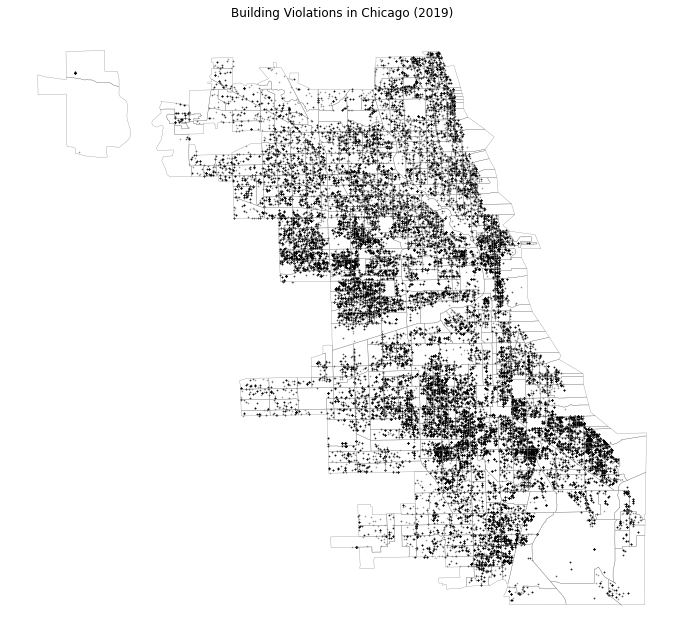

In [10]:
vio_clean = vio.dropna(subset=['latitude', 'longitude']) #get rid of NA lat/lon
fig, ax = plt.subplots(figsize=(12,12))

vio_clean.plot(
    ax=ax,
    color='#000000',
    markersize=.6,
    alpha=.3);

tracts.plot(
    ax=ax,
    facecolor="none",
    lw=0.3,
    edgecolor='gray')

ax.set_axis_off()
ax.set(title='Building Violations in Chicago (2019)');

There appears to be clusters of violations occurring in certain parts of the city, which could simply be due to the fact that there are more buildings in some areas than others (i.e., differing land uses). The periphery of the city also has fewer violations compared to the inner core. It's not too noticeable, but there appears to be a heavy concentration of violations in the South and West side of the city, as well as the Loop, compared to the North side. We'll come back to this.

Now let's categorize these points by `inspection_category` to see if there are any interesting patterns. This column tells us whether the inspection occurred due to a 311 complaint, a permit, or a periodic inspection that are typically legally required for some structures. 

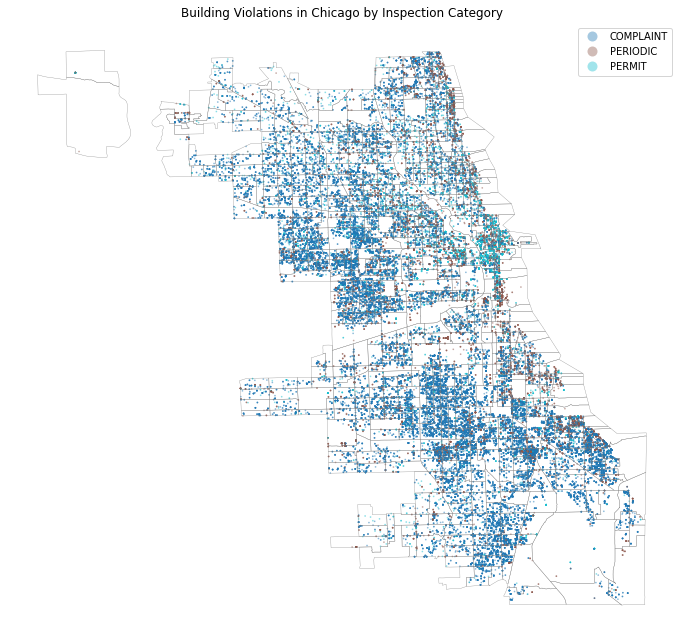

In [11]:
fig, ax = plt.subplots(figsize=(12,12))

vio_clean.plot(
    ax=ax,
    column="inspection_category", 
    legend = True,
    legend_kwds={'loc': 'upper right'},
    markersize=.6,
    alpha=.4);

tracts.plot(
    ax=ax,
    facecolor="none",
    lw=0.3,
    edgecolor='gray'
)

ax.set_axis_off()
ax.set(title='Building Violations in Chicago by Inspection Category');

It appears that, citywide, a majority of violations occur as a result of 311 complaints. However, there are visible concentrations of violations that occur in the Loop due to a permit, which makes sense since there's most likely a lot more construction there. There are also some violation clusters, particularly along the lakeshore, as a result of periodic inspections. A decent assumption would be that this happens because there are different building codes for lakefront properties than for non-lakefront, meaning those on the lakeshore get inspected (and cited) more often.

# Point Pattern Analysis

Now that we've got a basic understanding of the spatial distribution of building violations in Chicago, we can begin to apply some common algorithms to determine whether there are *non-random* clusters where more violations occur than others. The maps above do a decent job at visualizing spatial distribution, but we can derive some spatial statistics to see if there are underlying patterns that are not visually observable. 

First, let's calculate a couple measures of central tendency to identify the 'center of mass' of building violations. Using [centrography](https://pointpats.readthedocs.io/en/latest/api.html#centrography) from the [pointpats](https://pointpats.readthedocs.io/en/latest/index.html) python library, we calculate the mean center (i.e., the average of the coordinate values) and the median center (where exactly half of the data lies above, below & left, right of the point):

In [12]:
mean_center = centrography.mean_center(vio_clean[['longitude','latitude']])
median_center = centrography.euclidean_median(vio_clean[['longitude','latitude']])
print("Mean Center of Building Violations in Chicago:", mean_center)
print("Median Center of Building Violations in Chicago:",median_center)

Mean Center of Building Violations in Chicago: [-87.66746161  41.83475171]
Median Center of Building Violations in Chicago: [-87.66686624  41.83064528]


We can see that the mean and median are very close together. Below, we visualize these coordinates on top of Chicago's census tracts. It's important to pay attention to the cardinal position of the mean and median center relative to the Loop. This way, we can confirm whether the 'center of mass' for Chicago's building violations are indeed skewed to the West and South Side like we hypothesized from the spatial distribution maps above.

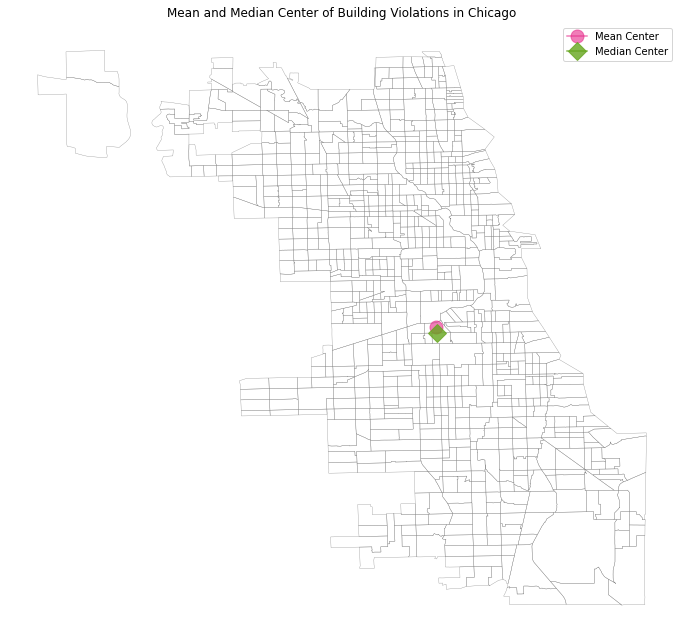

In [13]:
fig, ax = plt.subplots(figsize=(12, 12))

tracts.plot(
    ax=ax,
    facecolor="none",
    lw=0.3,
    edgecolor='gray'
)

plt.plot(mean_center[0],mean_center[1], color='#e7298a',marker='o', markersize=13, alpha=.6, label='Mean Center')
plt.plot(median_center[0],median_center[1], color='#66a61e',marker='D', markersize=13, alpha=.8, label='Median Center')

plt.legend()
ax.set_axis_off()
ax.set(title='Mean and Median Center of Building Violations in Chicago');

As we can see, both measures of central tendency skew towards the South and West Side of the city relative to the Loop. This is much more informative in understanding where the spatial distribution is *skewed* towards, meaning there is a higher density of points (building violations) in certain parts over others. 

Another way to better visualize the density of points is to create a grid matrix of *N* size on top of them and count how many points fall within each bin. This is a similar concept to that of a histogram, which places data into 'buckets' and counts how much data is in each bucket. In this case, we are calculating it in a spatial dimension. Using `hexbin` from the `matplotlib` library makes it quite simple to calculate this 2-D histogram. In this case, the grid we are using is divided into hexagonal cells, with a grid size of 50 (i.e., the number of hexagons in the x-direction). The resulting plot will then show if certain neighborhoods have a higher density of building violations than others. 

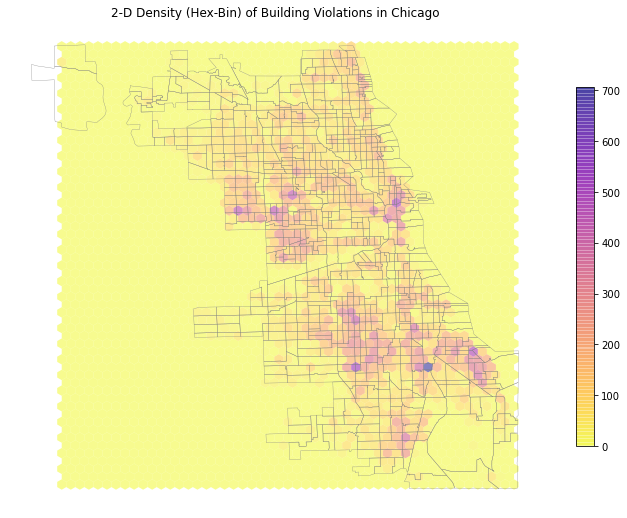

In [14]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(
    vio_clean['longitude'], 
    vio_clean['latitude'],
    gridsize=50, 
    linewidths=0,
    alpha=0.5, 
    cmap='plasma_r'
)

tracts.plot(
    ax=ax,
    facecolor="none",
    lw=0.3,
    edgecolor='gray'
)

plt.colorbar(hb, shrink=0.55) 

ax.set_axis_off()
ax.set(title='2-D Density (Hex-Bin) of Building Violations in Chicago');

As our measures of central tendency confirmed, there are pockets of a higher density of building violations in the South and West side of Chicago, as well as the Loop. This visualization removes the clutter of each point and aggregates based on a set of physical parameters (boundaries of each grid cell). However, much like histograms, one can decide how many 'bins' or 'grid cells' to create. This could lead to a misleading spatial analysis, due to the [modifiable area unit problem](https://www.gislounge.com/modifiable-areal-unit-problem-gis/). To reduce these issues, we can create a kernel density estimation (KDE) of the points instead, which is a 'non-parametric way to estimate the probability density function of a random variable ([source](https://en.wikipedia.org/wiki/Kernel_density_estimation)). Essentially, the KDE uses the kernel function which estimates the probability of a point being at a certain location (i.e., more points, higher probability) assigning a higher weight based on the distance to other points. Below we visualize a KDE plot with a Gaussian kernel function using the `kdeplot` function from the [seaborn](https://seaborn.pydata.org) python library. 

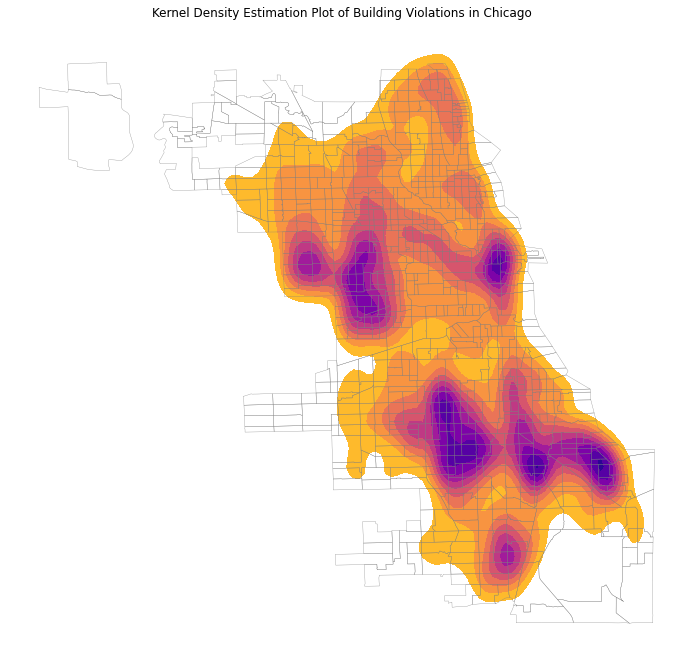

In [15]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.kdeplot(
    vio_clean['longitude'],
    vio_clean['latitude'],
    shade=True,
    cmap='plasma_r',
    shade_lowest=False,
    ax=ax
)

tracts.plot(
    ax=ax,
    facecolor="none",
    lw=0.3,
    edgecolor='gray'
)

ax.set_axis_off()
ax.set(title='Kernel Density Estimation Plot of Building Violations in Chicago');

This robust estimate of the density of building violations in Chicago confirms our hypothesis that certain neighborhoods experience higher building violations than others. In particular, neighborhoods in the South and West Side of the city experience acutely high number of building violations relative to others. The Loop is also an area of high density, as expected. Given that each violation points to a possible safety hazard or quality of life concern, the Point Pattern Analysis allowed us to discover which areas in the City of Chicago tax dollars should be invested in to upgrade older and vacant buildings. Bringing these buildings up to code will create a less hazardous environment and increase property values. 

However, now that we know where there are *non-random* clusters of violations, what potential relationships exist between `neighborhood socioeconomic and demographic characteristics (independent variable)` and `number of building violations (dependent variable)`? The following section attempts to answer this question.

# Regression Analysis

Using the ACS data we imported into `acs`, we will run either a Poisson or Negative Binomial regression based on the dispersion of the building violation data. Because building violations are represented as point data and ACS estimates are aggregations at the neighborhood (tract) level, we will have to do some data wrangling to make them comparable. To do this, we are going to count the number of building violation points within each census tract in Chicago. Then, we will join those building violation counts to the `tracts` polygon dataset. Lastly, we will join the `acs` and `tracts` dataset based on the `GEOID` column. This is the DataFrame which we will use to run our model.

In [16]:
##################################################### WARNING: ####################################################
# This cell takes >3 hours to run. For the efficiency of this notebook, I've ran this code cell 
# and saved the output to a shapefile called 'tracts.shp' which will replace the tracts polygons we've used to 
# create maps so far. The code for this geoprocessing step is commented out below.
###################################################################################################################

# aggregates point data at the census tract level
#pts = vio.copy() #create a copy to speed up process

#create empty list of point-in-polygon counts
#pip = []

# Loop over tracts
#for i, poly in tracts.iterrows():
    
    # empty list tracks point in tract i
    #pip_loop = []
    
    # loop over each building violation
    #for j, point in pts.iterrows():
        #if poly.geometry.contains(point.geometry):
            # if true, then we add that point to the pip_loop list
            #pip_loop.append(point.geometry)
            #pts = pts.drop([j])
    # count how many point geometries were appended to the pip_loop list
    #pip.append(len(pip_loop))
# add this list as a column to the tracts dataset 
#tracts['buildingvi'] = pd.Series(pip)

In [17]:
tracts = gpd.read_file('Data/tracts.shp') #read shapefile of output from cell above

Let's take a look at the top 5 census tracts with the most building violations.

In [18]:
tracts.sort_values('buildingvi', ascending=False).head()

,statefp10,name10,commarea_n,namelsad10,commarea,geoid10,notes,tractce10,countyfp10,buildingvi,geometry
96,17,8391,32,Census Tract 8391,32,17031839100,None,839100,031,719,"POLYGON ((-87.63581 41.88738, -87.63544 41.887..."
595,17,2315,23,Census Tract 2315,23,17031231500,None,231500,031,667,"POLYGON ((-87.72098 41.88802, -87.72179 41.887..."
385,17,3301,33,Census Tract 3301,33,17031330100,None,330100,031,600,"POLYGON ((-87.62742 41.86734, -87.62742 41.867..."
66,17,8330,28,Census Tract 8330,28,17031833000,None,833000,031,598,"POLYGON ((-87.65203 41.88170, -87.65226 41.881..."
257,17,4401.01,44,Census Tract 4401.01,44,17031440101,None,440101,031,591,"POLYGON ((-87.59890 41.74541, -87.59956 41.745..."


719 building violations were issued in tract 17031839100. It's not a surprise where that tract is located:

![highest tract](highest_tract.png)

Let's look at the `acs` dataset to see which neighborhood characteristics we have at the census tract level. 

In [19]:
acs.head()

,GEOID,NAME,medhomeval,medhhincome,poverty_rate,bachelors_rate,pBlack,pHispanic,vacancy_rate
0,17031010100,"Census Tract 101, Cook County, Illinois",252800.0,32474.0,0.316808,0.293646,0.444662,0.113720,0.101862
1,17031010201,"Census Tract 102.01, Cook County, Illinois",169700.0,45639.0,0.371563,0.192537,0.332797,0.224145,0.078806
2,17031010202,"Census Tract 102.02, Cook County, Illinois",175200.0,41486.0,0.200622,0.208188,0.336326,0.260014,0.104101
3,17031010300,"Census Tract 103, Cook County, Illinois",189500.0,41250.0,0.110871,0.203462,0.307633,0.169468,0.086314
4,17031010400,"Census Tract 104, Cook County, Illinois",217000.0,39700.0,0.150585,0.414874,0.211778,0.075197,0.106918


For each tract in Chicago, we have median home values, median household income, the poverty rate, the rate of adults over 25 with a bachelors degree, the share of the population that identifies as Black and Hispanic, and the housing vacancy rate. 

Now, we join the `acs` and `tracts` datasets together based on the `GEOID` column in each.

In [20]:
tracts = tracts.rename(columns={"buildingvi": "vio_count", "geoid10": "GEOID"}) #rename cols
tracts.GEOID = tracts.GEOID.astype(str) #convert to string
acs.GEOID = acs.GEOID.astype(str) #convert to string
modeldata = tracts.merge(acs, on='GEOID', how='left') #left join 

#create list of unecessary columns
dropcols = ['statefp10', 'name10', 'commarea_n', 'namelsad10', 'commarea','notes','tractce10','countyfp10','NAME']
modeldata = modeldata.drop(dropcols,axis=1) #drop cols in dropcols list

Here's what the dataset to fit our model looks like. `vio_count` is the number of building violation points in each tract. 

In [21]:
modeldata.head()

,GEOID,vio_count,geometry,medhomeval,medhhincome,poverty_rate,bachelors_rate,pBlack,pHispanic,vacancy_rate
0,17031842400,218,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",145300.0,47669.0,0.231992,0.174766,0.970798,0.005516,0.146091
1,17031840300,118,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",219000.0,50607.0,0.191968,0.156224,0.031615,0.628881,0.075211
2,17031841100,217,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",286500.0,35723.0,0.301036,0.181818,0.006161,0.021423,0.048184
3,17031841200,135,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",183800.0,45700.0,0.174444,0.228130,0.054078,0.740297,0.148360
4,17031839000,151,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",299800.0,105094.0,0.178195,0.399216,0.116625,0.096319,0.169497


We can also plot `vio_count` to see the spatial distribution of building violations at the tract level. 

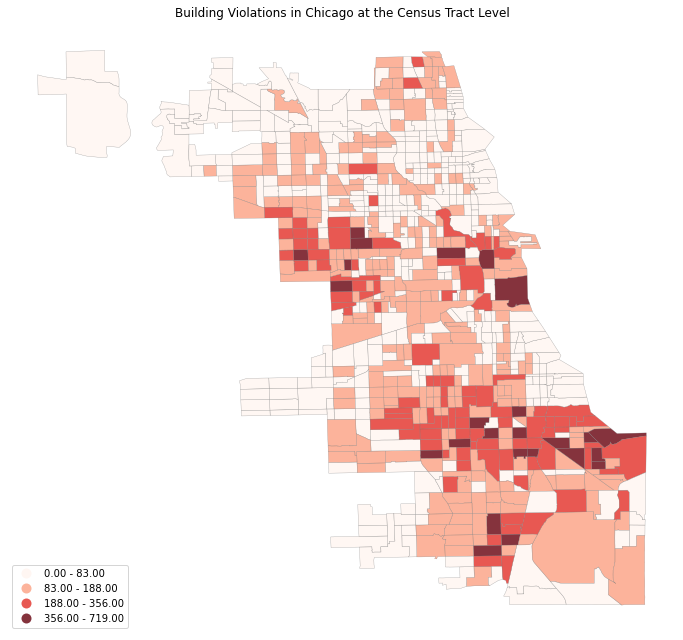

In [22]:
fig, ax = plt.subplots(figsize=(12,12))

modeldata.plot(
    ax=ax,
    column="vio_count", 
    cmap = "Reds",
    legend = True,
    legend_kwds={'loc': 'lower left'},
    alpha=0.8, 
    k=4,
    edgecolor='gray',
    scheme='NaturalBreaks',
    linewidth = .3);

ax.set_axis_off()
ax.set(title='Building Violations in Chicago at the Census Tract Level');

### Modeling Count Data: Poisson or Negative Binomial

The Poisson and Negative Binomial models are some of the most commonly used when dealing with count data. However, the Poisson model assumes that the count data is not over- or under-dispersed (meaning that the model assumes that the mean is equal to the variance). Let's check to see what kind of dispersion the building violation count has. 

In [23]:
print("The mean of vio_count is:", modeldata['vio_count'].mean())
print("The variance of vio_count is:", modeldata['vio_count'].var())

The mean of vio_count is: 110.95131086142322
The variance of vio_count is: 9667.326376404495


Building violation counts in our dataset are over-dispersed (variance > mean), therefore we will use a Negative Binomial model. 

Here, we use the `statsmodels` python library to fit the Negative Binomial model to our data. The `formula` string specifies the dependent (left of the ~) and independent (right of the ~) variables in our model. The `summary()` function from `statsmodels` provides a neat summary of the model's estimates, including coefficients, measures of statistical significance, and confidence intervals. 

In [24]:
formula = "vio_count ~ medhomeval+medhhincome+poverty_rate+bachelors_rate+pBlack+pHispanic+vacancy_rate"
model = smf.glm(formula = formula, data=modeldata, family=sm.families.NegativeBinomial()).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              vio_count   No. Observations:                  783
Model:                            GLM   Df Residuals:                      775
Model Family:        NegativeBinomial   Df Model:                            7
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4401.6
Date:                Mon, 11 Oct 2021   Deviance:                       369.79
Time:                        22:36:02   Pearson chi2:                     406.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.5571      0.270     13.177      0.000       3.028       4.086
medhomeval     -9.145e-07   4.54e-07     -2.016      0.044    -1.8e-06   -2.53e-08
medhhincome     5.455e-06   2.31e-06      2.363      0.018    9.31e-07    9.98e-06
poverty_rate       1.1539      0.471      2.448      0.014       0.230       2.078
bachelors_rate     0.3119      0.554      0.563      0.573      -0.773       1.397
pBlack             0.7719      0.213      3.621      0.000       0.354       1.190
pHispanic          0.4520      0.244      1.856      0.063      -0.025       0.929
vacancy_rate       2.3827      0.564      4.221      0.000       1.276       3.489
==================================================================================
"""

To evaluate the estimates of our model, we must first transform the Beta coefficients into something more interpretable. Right now, these coefficients represent the difference in the log of the outcome variable when the predictor increases/decreases by 1 unit. If we exponentiate the coefficients, we can report the multiplicative factor of each coefficient instead and estimate the number of building violations based on this factor. 

For example, we can see that there is a statistically significant relationship between `poverty_rate` and `vio_count` based on the test statistic and P value. So, let's exponentiate the `poverty_rate` coefficient.

In [25]:
math.exp(1.1539)

3.1705339113485764

The multiplicative factor for `poverty_rate` is ~3.2, meaning that, all else being equal, the expected number of building violations changes by a multiplicative factor of 3.2 for each additional unit increase in the poverty rate. In other words, for every 1% increase in the poverty rate, the number of building violations increases by `(1-math.exp(1.1539))*100`, which is equal to an increase in violations by 217%.

Likewise, we can estimate the relationship between median home values and building violations. The model finds that this relationship is also statistically significant. So, how does every 10,000 dollar increase in median home values affect the number of building violations in Chicago? First, we multiply our coefficient by 10,000, then exponentiate to get the multiplicative factor. 

In [26]:
math.exp(-0.000009145*10000) #med home val

0.9126069453585395

So, all else equal, the expected number of building violations changes by a multiplicative factor of .91 for each additional 10,000 dollars in median home values. This means for every 10,000 dollar increase in median tract home values, the model estimates there will be *decrease* in tract building violation counts by ~9%. 

At a high level, what did the model uncover about building violations and socioeconomic/demographic characteristics at the neighborhood level? We can see that neighborhoods which have a higher vacancy rate, poverty rate, share of the population which is Black or Hispanic also tend to see higher counts of building violations. Additionally, we found that neighborhoods with higher median home values had lower building violations counts. However, the model also discredited some pre-conceived assumptions we might have had. Particularly, it found that neighborhoods with a higher education attainment (`bachelors_rate`) and median household income (`medhhincome`) had higher building violation counts. This is perhaps due to the high concentration of building violations in the Loop, the downtown neighborhood which also happens to have residents with high educational attainment and higher income.

# Conclusion

In this notebook, we performed the following goals: 

- Developed a variety of geospatial visualizations to understand the spatial distribution of building violations in Chicago
- Conducted a point pattern analysis on building violations to identify potential geographic clusters
- Determined whether there is a statistically significant relationship between building violations and neighborhood socioeconomic and demographic characterstics using a multivariate Negative Binomial regression model